In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from random import randint

In [ ]:
#right = randint(2,5)
#k = randint(5,10)
k=5
right=4
left = 2*k
print("Total elements:")
n= left+right
print(n)
print("Left elements:")
print(left)
print("Right elements:")
print(right)
print("Number of edges")
m = randint(0,left*right-left)
print(m+left)#every left node needs at least one edge
colors = ['red','green','gray','yellow']
node_to_color = [colors[0] for i in range(k)]+[colors[1] for i in range(k)]+[colors[2] for i in range(right)]

Total elements:
14
Left elements:
10
Right elements:
4
Number of edges
33


In [ ]:
def get_fan_color(fan):
    if(fan<k): return 0
    else: return 1

In [ ]:
def generate():
    B = nx.Graph()
    B.add_nodes_from([i for i in range(left)], bipartite=0) # Add the node attribute "bipartite"
    B.add_nodes_from([i for i in range(left,n)], bipartite=1)
    for i in range(left):#every left node needs at least one edge
        partner = randint(left,n-1)
        B.add_edge(i,partner)
    for i in range(m):#assign remaining random edges
        partner_left = randint(0,left-1)
        partner_right = randint(left,n-1)
        while(B.has_edge(partner_left,partner_right)):
            partner_left = randint(0,left-1)
            partner_right = randint(left,n-1)
        B.add_edge(partner_left,partner_right)
    node_to_bar = [0 for i in range(left)]
    bar_to_ratio = [(0,0) for i in range(right)] 
    for i in range(left):
        color = get_fan_color(i)
        edges = list(B.edges(i))
        rand_edge = randint(0,len(edges)-1)
        neighbor = edges[rand_edge][1]
        node_to_bar[i]= neighbor
        nei_index = neighbor-left
        if(color==0): bar_to_ratio[nei_index] = (bar_to_ratio[nei_index][0]+1,bar_to_ratio[nei_index][1])
        else: bar_to_ratio[nei_index] = (bar_to_ratio[nei_index][0],bar_to_ratio[nei_index][1]+1)
    # Separate by group
    l= [i for i in range(left)]
    r = [i for i in range(left)]
    pos = nx.bipartite_layout(B, l)
    return B,node_to_bar,bar_to_ratio,pos
B,node_to_bar,bar_to_ratio,pos = generate()

In [ ]:
def draw_graph(change_fan=-1,prev_bar=-1):
    edge_color = []
    for edge in B.edges():
        fan = edge[0]
        bar = edge[1]
        fan_color = get_fan_color(fan)
        if(fan==change_fan and bar==prev_bar): edge_color.append(colors[3])
        elif(bar==node_to_bar[fan]): edge_color.append(colors[fan_color])
        else: edge_color.append(colors[2])
    nx.draw(B, with_labels=True, pos=pos,node_color=node_to_color, edge_color=edge_color)
    plt.show()

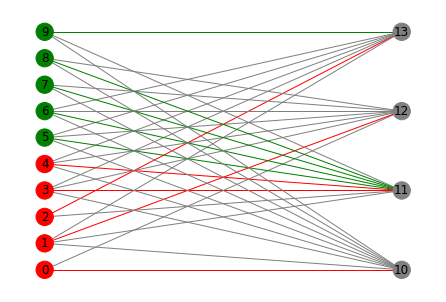

In [ ]:
draw_graph()

In [ ]:
def get_ratio(fan, bar):
    color = get_fan_color(fan)
    tmp = bar_to_ratio[bar-left]
    if(node_to_bar[fan]==bar): return tmp
    else:
        if(color==0): return (tmp[0]+1,tmp[1])
        else: return (tmp[0],tmp[1]+1)

def update_bar(bar,color,entering):
    tmp = bar_to_ratio[bar-left]
    if(entering):
        if(color==0): bar_to_ratio[bar-left] = (tmp[0]+1,tmp[1])
        else: bar_to_ratio[bar-left] = (tmp[0],tmp[1]+1)
    else:
        if(color==0): bar_to_ratio[bar-left] = (tmp[0]-1,tmp[1])
        else: bar_to_ratio[bar-left] = (tmp[0],tmp[1]-1)

def improve_situation(fan,draw=False):
    edges = B.edges(fan)
    color = get_fan_color(fan)
    curr_bar = node_to_bar[fan]
    prev_bar = curr_bar
    curr_ratio = get_ratio(fan,curr_bar)
    prev_ratio = curr_ratio
    change=False
    for edge in edges:
        bar = edge[1]
        ratio = get_ratio(fan,bar)
        delta =  curr_ratio[color] * (ratio[0]+ratio[1]) - ratio[color] * (curr_ratio[0]+curr_ratio[1])
        if(delta<0):
            curr_ratio = ratio
            update_bar(curr_bar,color,entering=False)
            update_bar(bar,color,entering=True)
            curr_bar=bar
            node_to_bar[fan]=curr_bar
            change=True
    if(change and draw): 
        print(str(prev_bar) +" -> "+str(node_to_bar[fan]))
        print(str(prev_ratio[color])+" / "+str(prev_ratio[0]+prev_ratio[1]) + " -> " + str(curr_ratio[color])+" / "+str(curr_ratio[0]+curr_ratio[1]))
        print(str(int(prev_ratio[color]*100/(prev_ratio[0]+prev_ratio[1])))+ "% ->"+ str(int(curr_ratio[color]*100/(curr_ratio[0]+curr_ratio[1])))+"%")
    return change
def run(draw=False):
    if(draw): print("welfare : "+str(social_welfare())) 
    first_iteration=True
    j=0
    while(first_iteration or change):
        first_iteration=False
        change=False
        for i in range(left):
            prev_bar = node_to_bar[i]
            improved = improve_situation(i,draw=draw)
            if(improved):
                tmp = node_to_color[i]
                node_to_color[i]='yellow' 
                if(draw):
                    print("welfare : "+str(social_welfare()))  
                    draw_graph(i, prev_bar)
                node_to_color[i]=tmp
            change = change or improved
        j += 1
    return j

def social_welfare():
    sum=0
    for fan in range(left):
        bar = node_to_bar[fan]
        color = get_fan_color(fan)
        ratio = get_ratio(fan,bar)
        sum+= ratio[color]/(ratio[0]+ratio[1])
    return sum

In [ ]:
from tqdm.notebook import trange
import copy
maxp=0
maxups = []
for i in trange(100000): 
    B,node_to_bar,bar_to_ratio,pos = generate()#10^5 Aufrufe, Instanz ist 10^2 groß
    tmp = copy.deepcopy((B,node_to_bar,bar_to_ratio,pos))
    performance = run()
    if(performance>=maxp):
        if(performance==maxp): maxups.append(tmp)
        else: 
            maxups = []
            maxups.append(tmp)
        maxp=performance

  0%|          | 0/100000 [00:00<?, ?it/s]

In [ ]:
print(maxp)

4


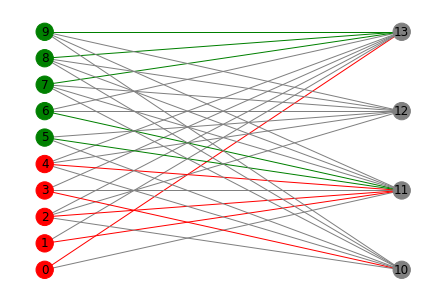

welfare : 6.1
13 -> 11
1 / 4 -> 4 / 6
25% ->66%
welfare : 7.333333333333333


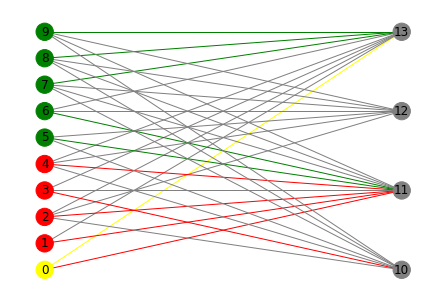

11 -> 12
4 / 6 -> 1 / 1
66% ->100%
welfare : 7.6000000000000005


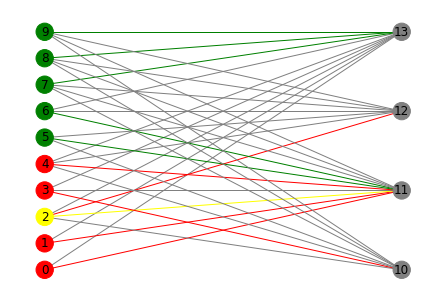

11 -> 12
3 / 5 -> 2 / 2
60% ->100%
welfare : 8.0


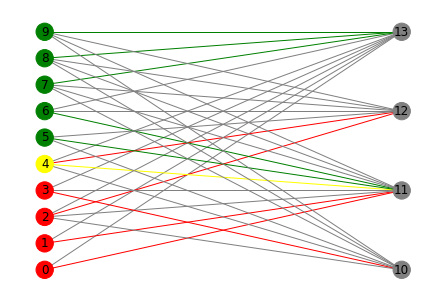

11 -> 13
2 / 4 -> 4 / 4
50% ->100%
welfare : 8.666666666666666


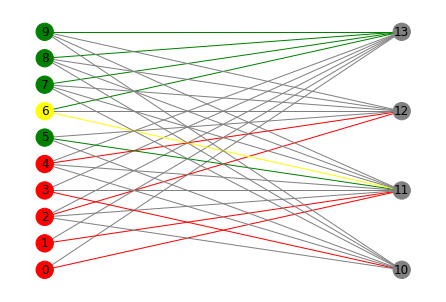

11 -> 10
1 / 3 -> 1 / 2
33% ->50%
welfare : 9.0


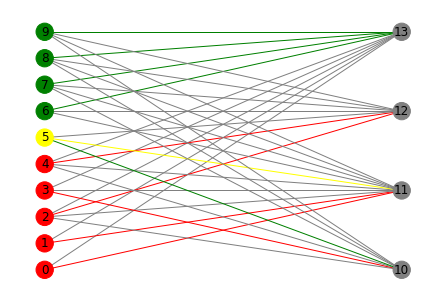

10 -> 11
1 / 2 -> 3 / 3
50% ->100%
welfare : 10.0


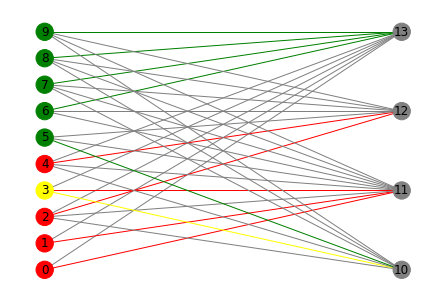

next?


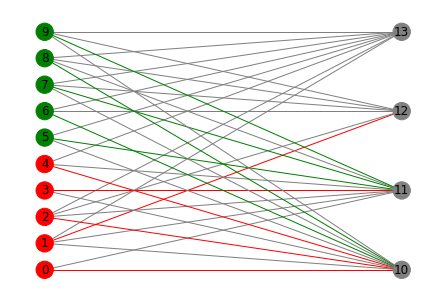

welfare : 6.1000000000000005
10 -> 12
3 / 5 -> 2 / 2
60% ->100%
welfare : 6.5


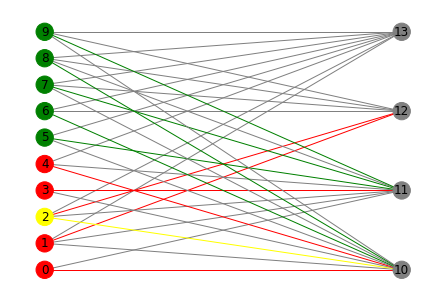

11 -> 10
1 / 4 -> 3 / 5
25% ->60%
welfare : 7.600000000000001


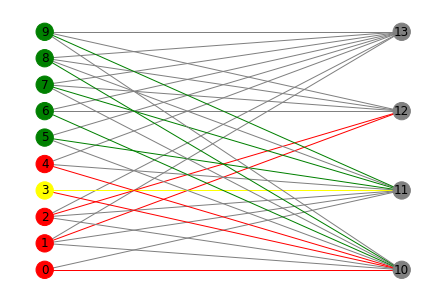

10 -> 13
3 / 5 -> 1 / 1
60% ->100%
welfare : 8.0


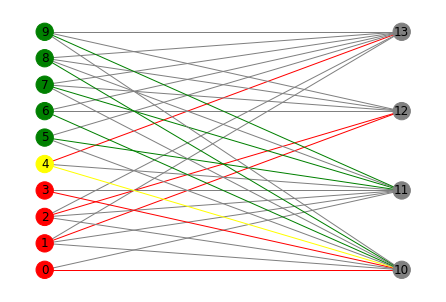

10 -> 11
2 / 4 -> 4 / 4
50% ->100%
welfare : 8.666666666666666


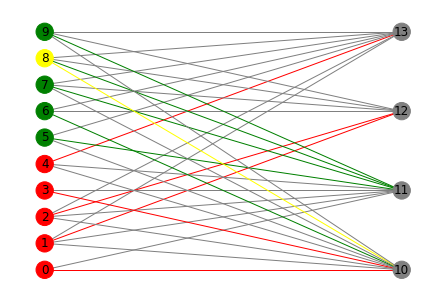

10 -> 13
1 / 3 -> 1 / 2
33% ->50%
welfare : 9.0


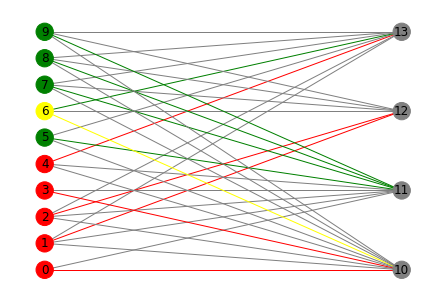

13 -> 10
1 / 2 -> 3 / 3
50% ->100%
welfare : 10.0


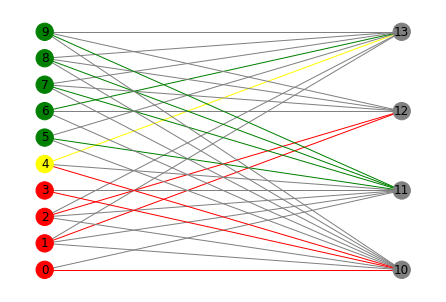

next?


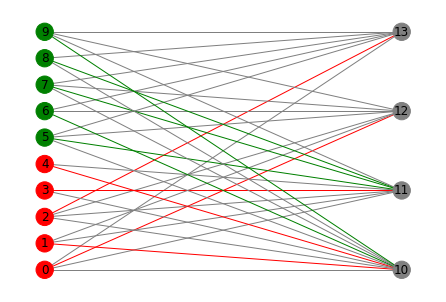

welfare : 6.5
10 -> 12
2 / 4 -> 2 / 2
50% ->100%
welfare : 7.166666666666668


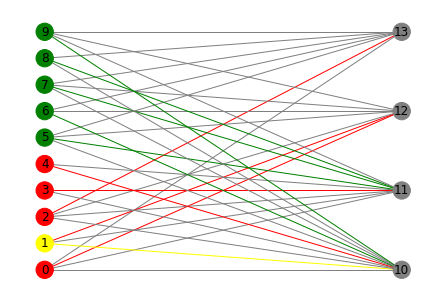

11 -> 10
1 / 4 -> 2 / 4
25% ->50%
welfare : 8.0


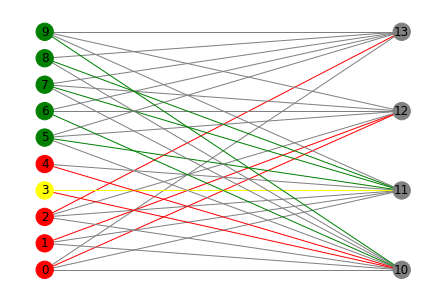

10 -> 11
2 / 4 -> 4 / 4
50% ->100%
welfare : 8.666666666666666


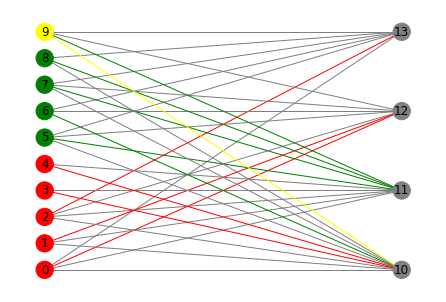

10 -> 13
1 / 3 -> 1 / 2
33% ->50%
welfare : 9.0


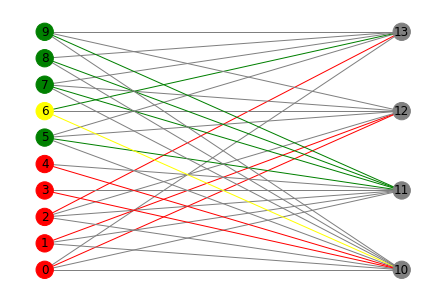

13 -> 10
1 / 2 -> 3 / 3
50% ->100%
welfare : 10.0


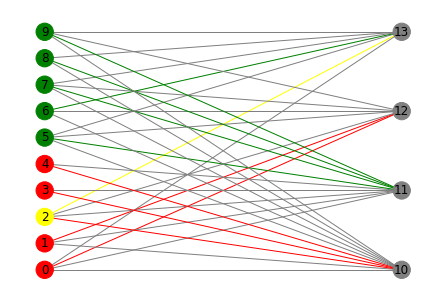

next?


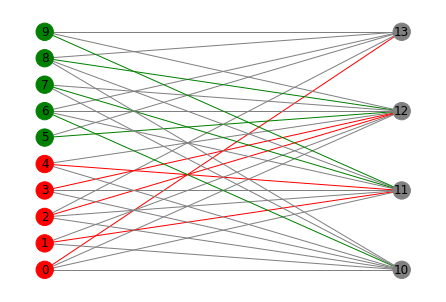

welfare : 6.0
11 -> 12
2 / 4 -> 3 / 5
50% ->60%
welfare : 6.2666666666666675


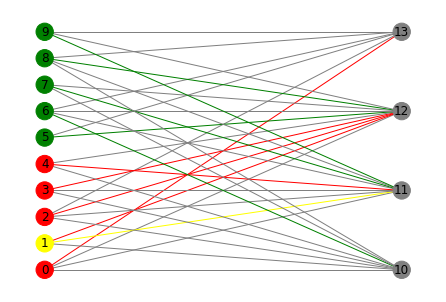

12 -> 13
3 / 5 -> 2 / 2
60% ->100%
welfare : 6.666666666666668


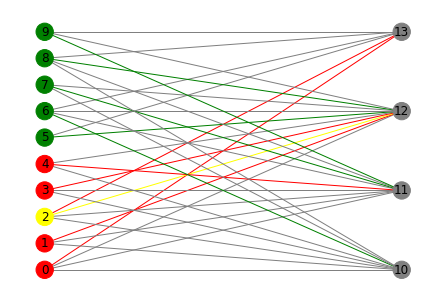

11 -> 12
1 / 3 -> 3 / 5
33% ->60%
welfare : 7.6000000000000005


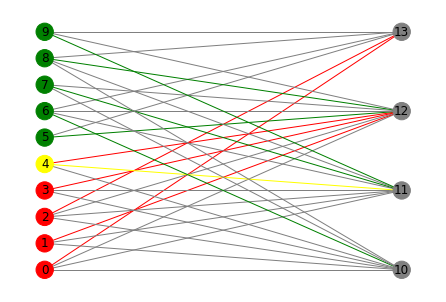

12 -> 11
2 / 5 -> 3 / 3
40% ->100%
welfare : 8.5


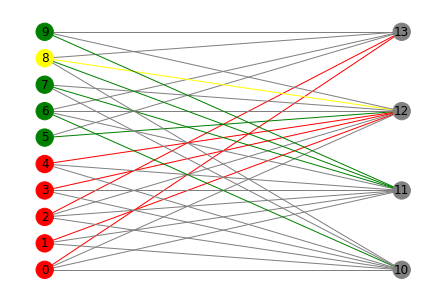

12 -> 13
1 / 4 -> 1 / 3
25% ->33%
welfare : 8.666666666666666


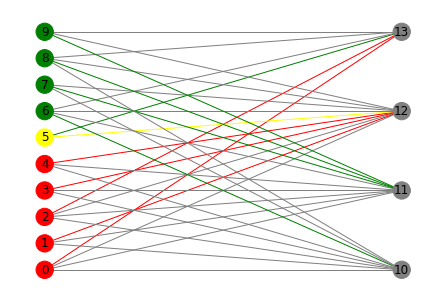

13 -> 12
2 / 3 -> 4 / 4
66% ->100%
welfare : 9.0


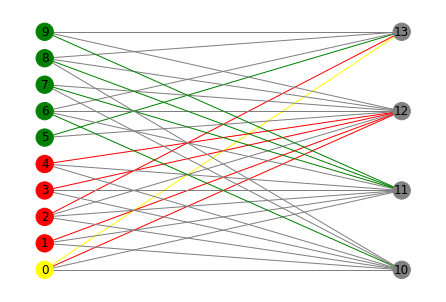

13 -> 12
1 / 2 -> 5 / 5
50% ->100%
welfare : 10.0


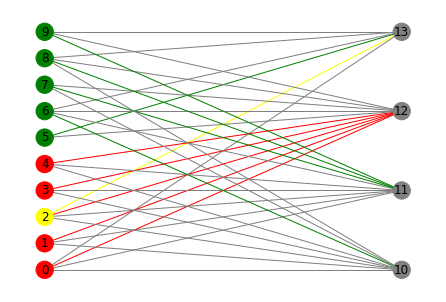

next?


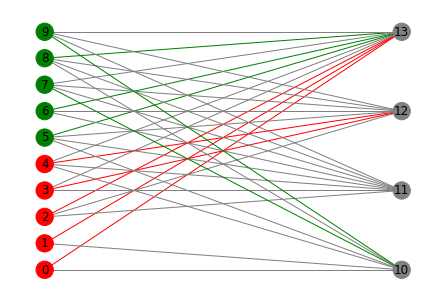

welfare : 7.0
13 -> 11
3 / 6 -> 1 / 1
50% ->100%
welfare : 7.599999999999999


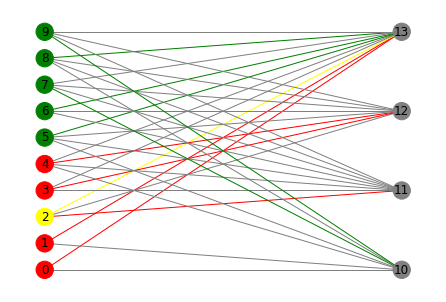

13 -> 10
3 / 5 -> 3 / 3
60% ->100%
welfare : 8.0


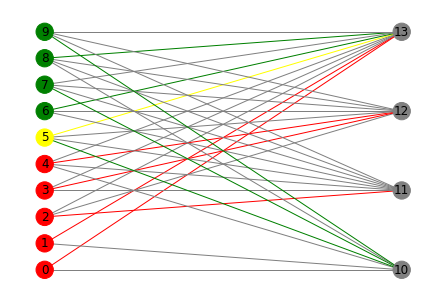

13 -> 10
2 / 4 -> 4 / 4
50% ->100%
welfare : 8.666666666666666


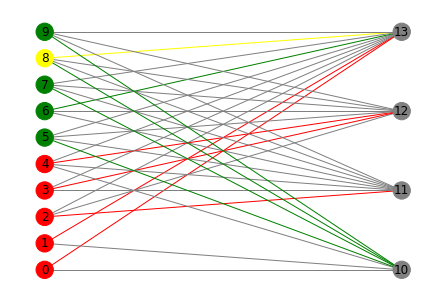

13 -> 11
1 / 3 -> 1 / 2
33% ->50%
welfare : 9.0


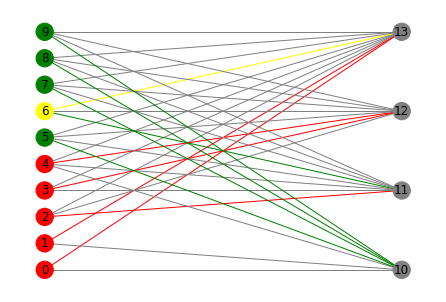

11 -> 13
1 / 2 -> 3 / 3
50% ->100%
welfare : 10.0


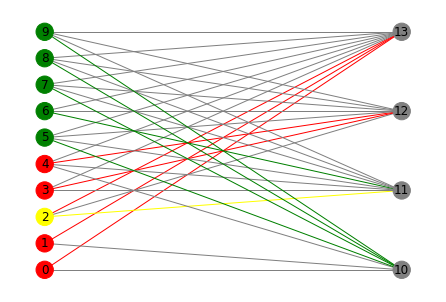

next?


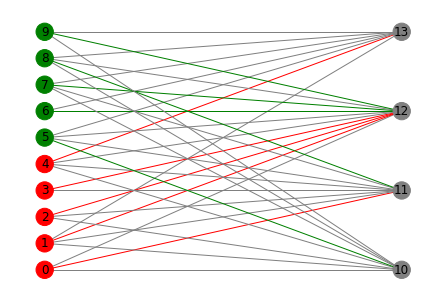

welfare : 6.0
11 -> 12
1 / 2 -> 4 / 7
50% ->57%
welfare : 6.571428571428572


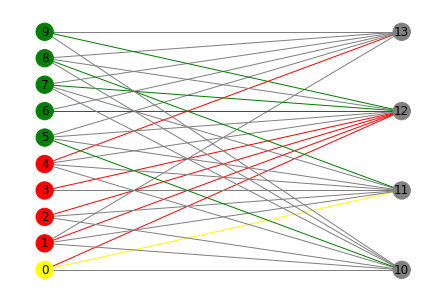

12 -> 13
4 / 7 -> 2 / 2
57% ->100%
welfare : 7.0


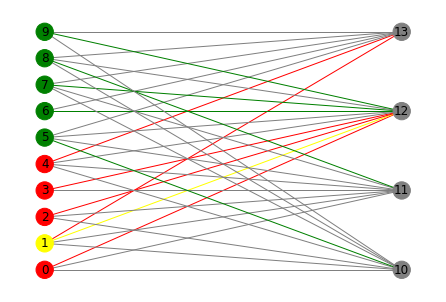

12 -> 11
3 / 6 -> 2 / 2
50% ->100%
welfare : 7.600000000000001


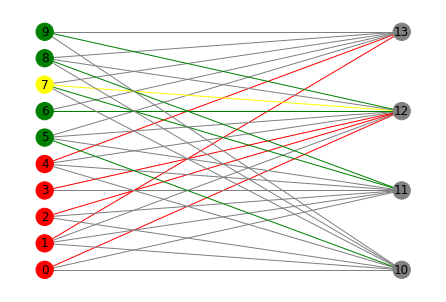

12 -> 10
2 / 5 -> 2 / 2
40% ->100%
welfare : 8.5


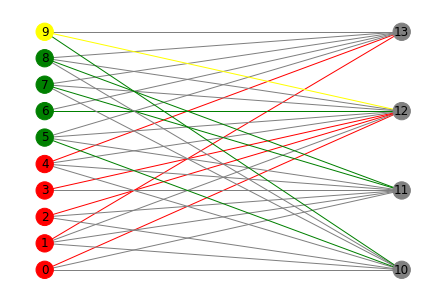

12 -> 13
1 / 4 -> 1 / 3
25% ->33%
welfare : 8.666666666666666


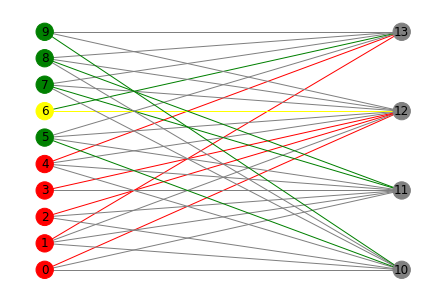

13 -> 12
2 / 3 -> 4 / 4
66% ->100%
welfare : 9.0


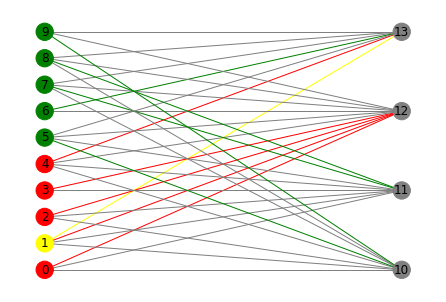

13 -> 12
1 / 2 -> 5 / 5
50% ->100%
welfare : 10.0


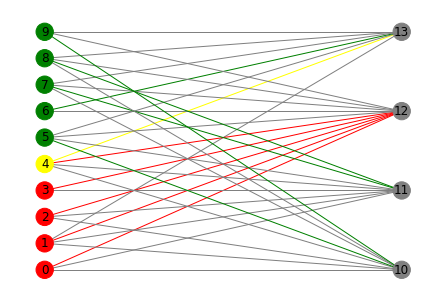

next?


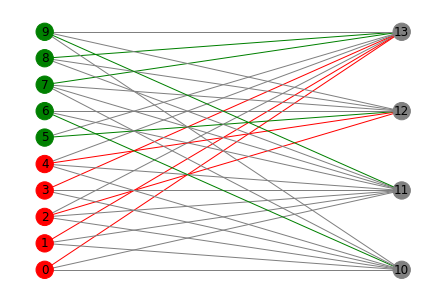

welfare : 6.2666666666666675
12 -> 13
1 / 3 -> 3 / 6
33% ->50%
welfare : 7.0


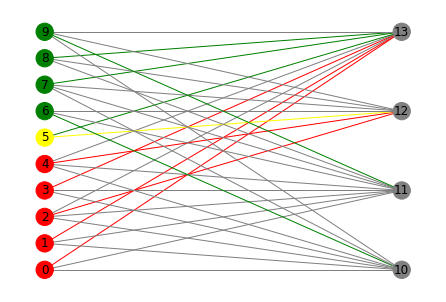

13 -> 11
3 / 6 -> 2 / 2
50% ->100%
welfare : 7.6000000000000005


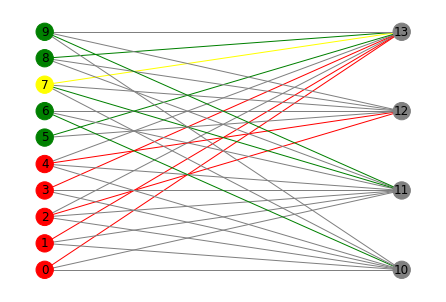

13 -> 11
2 / 5 -> 3 / 3
40% ->100%
welfare : 8.5


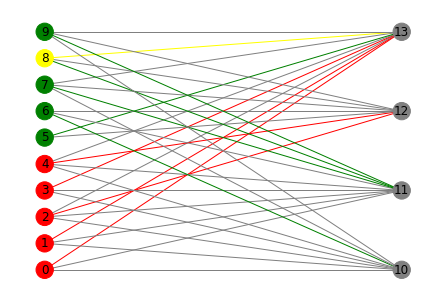

13 -> 12
1 / 4 -> 1 / 3
25% ->33%
welfare : 8.666666666666666


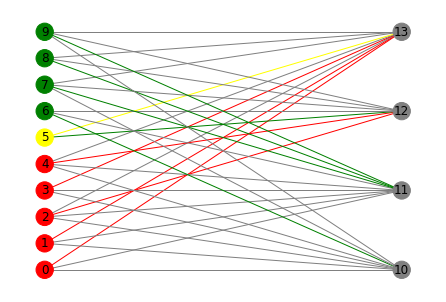

12 -> 13
2 / 3 -> 4 / 4
66% ->100%
welfare : 9.0


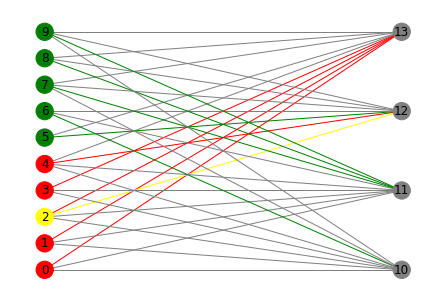

12 -> 13
1 / 2 -> 5 / 5
50% ->100%
welfare : 10.0


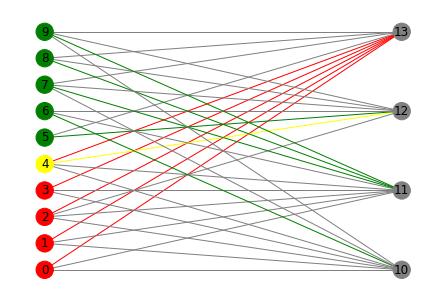

next?


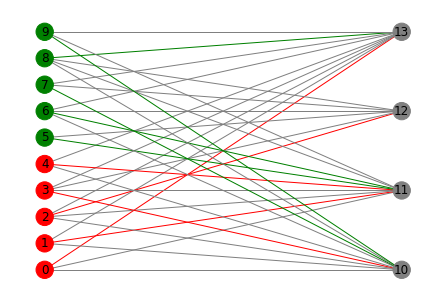

welfare : 5.666666666666667
13 -> 11
1 / 2 -> 3 / 5
50% ->60%
welfare : 6.2666666666666675


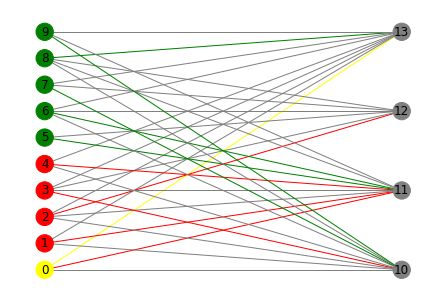

10 -> 12
1 / 3 -> 2 / 2
33% ->100%
welfare : 7.6000000000000005


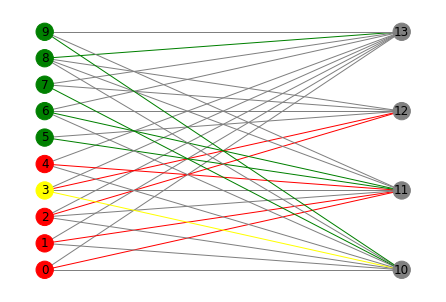

11 -> 13
2 / 5 -> 2 / 2
40% ->100%
welfare : 8.5


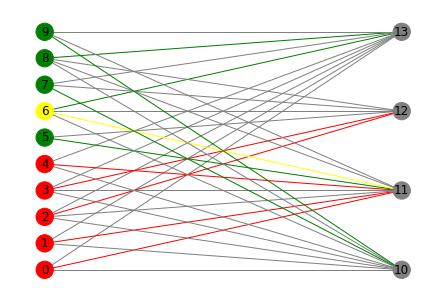

11 -> 12
1 / 4 -> 1 / 3
25% ->33%
welfare : 8.666666666666666


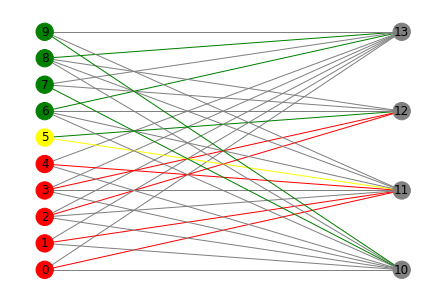

12 -> 11
2 / 3 -> 4 / 4
66% ->100%
welfare : 9.0


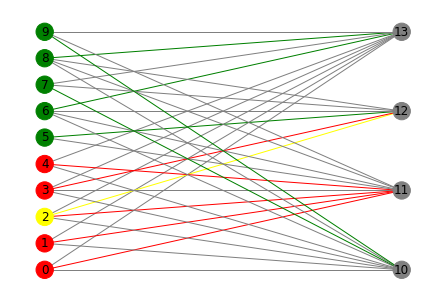

12 -> 11
1 / 2 -> 5 / 5
50% ->100%
welfare : 10.0


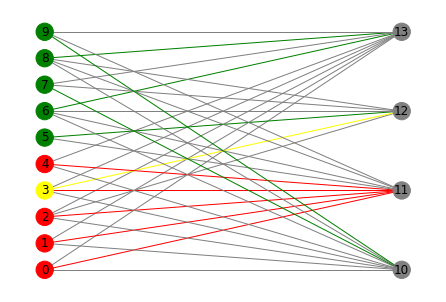

next?


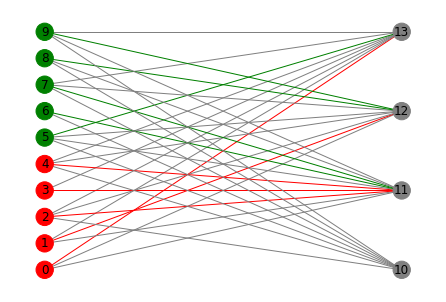

welfare : 5.266666666666667
13 -> 11
1 / 2 -> 4 / 6
50% ->66%
welfare : 6.0


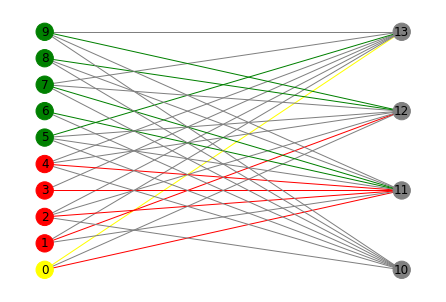

12 -> 11
1 / 3 -> 5 / 7
33% ->71%
welfare : 7.142857142857142


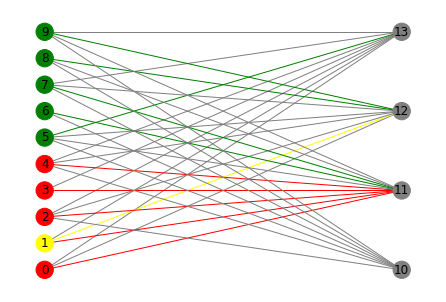

11 -> 10
5 / 7 -> 1 / 1
71% ->100%
welfare : 7.333333333333332


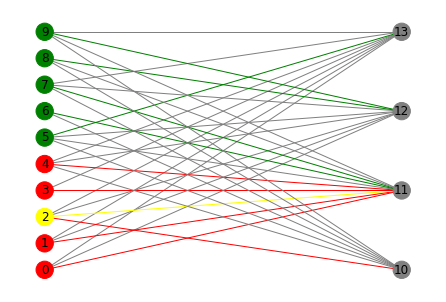

11 -> 10
4 / 6 -> 2 / 2
66% ->100%
welfare : 7.600000000000001


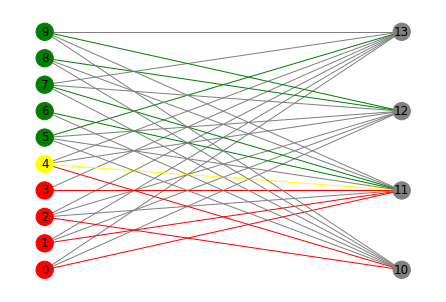

11 -> 12
2 / 5 -> 3 / 3
40% ->100%
welfare : 8.5


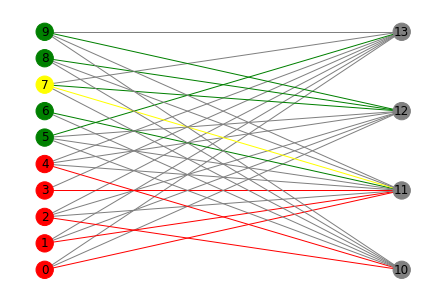

11 -> 10
1 / 4 -> 1 / 3
25% ->33%
welfare : 8.666666666666666


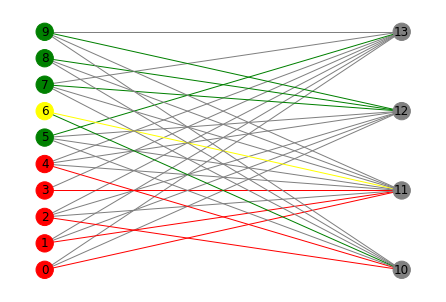

10 -> 11
2 / 3 -> 4 / 4
66% ->100%
welfare : 9.0


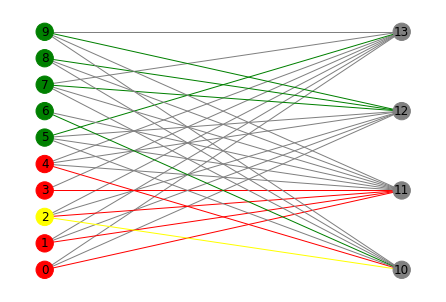

10 -> 11
1 / 2 -> 5 / 5
50% ->100%
welfare : 10.0


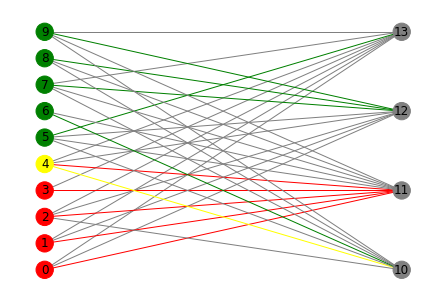

next?


In [ ]:
for backup in maxups:
    B,node_to_bar,bar_to_ratio,pos = backup
    draw_graph()
    run(draw=True)
    input("next?")